In [126]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from scipy.signal import convolve2d
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import eigsh, eigs
import os
import cv2
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import inv
import time

In [7]:
data_coil = np.load('processed_images.npy')
labels_coil = np.load('labels.npy')

In [8]:
print(data_coil)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[6 6 6 ... 6 6 6]
  [6 6 6 ... 6 6 6]
  [6 6 6 ... 6 6 6]
  ...
  [6 6 6 ... 6 6 6]
  [6 6 6 ... 6 6 6]
  [6 6 6 ... 6 6 6]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[4 4 4 ... 4 4 4]
  [4 4 4 ... 4 4 4]
  [4 4 4 ... 4 4 4]
  ...
  [4 4 4 ... 4 4 4]
  [4 4 4 ... 4 4 4]
  [4 4 4 ... 4 4 4]]

 [[5 5 5 ... 5 5 5]
  [5 5 5 ... 5 5 5]
  [5 5 5 ... 5 5 5]
  ...
  [5 5 5 ... 5 5 5]
  [5 5 5 ... 5 5 5]
  [5 5 5 ... 5 5 5]]]


# Preprocessing

### convolve 2 times with an average filter (3 x 3 all ones matrix)

In [10]:

def smooth(img, filter_size=3, num_iter=2):
    average_filter = np.ones((filter_size, filter_size)) / (filter_size ** 2)

    for i in range(num_iter):
        smoothed_img = convolve2d(img, average_filter, mode='same')

    return smoothed_img


In [11]:

# convolution 3x3 2 times
data_smoothed = np.array([smooth(img) for img in data_coil])

data_flatten = data_smoothed.reshape(data_smoothed.shape[0], -1)
pca = PCA(n_components=100)
data_pca = pca.fit_transform(data_flatten)

data_pca.shape

#数据是random的么，我看着为什么都一样的

(1440, 100)

### use top 50 PCA

In [12]:
k = 25
m = 20
sigma = 1

img = data_pca[:1000]
label = labels_coil[:1000]

# choose first 100 data to be labeled
num_labels = 250
labeled_indices = np.arange(num_labels)
unlabeled_indices = np.arange(num_labels, 1000)

In [38]:
unique_values = np.unique(labels_coil)
number_of_unique_values = len(unique_values)

print(f"Number of unique labels: {number_of_unique_values}")

Number of unique labels: 20


# Graph construction

In [91]:
def graph_construction(X, k, m, sigma=1):
    """
    X: data
    k: k-th neareast neighbors
    m: self-tuning neighbor index (m<k)
    sigma: local time
    """
    
    # includes the point itself as the 0-th nearest
    knn = NearestNeighbors(n_neighbors=k+1, algorithm='auto', metric='euclidean')

    knn.fit(X)

    # Get the k nearest neighbors for each data point
    distances, indices = knn.kneighbors(X)
    
    # Compute self-tuning weights
    num_points = X.shape[0]
    W_dense = np.zeros((num_points, num_points))

    for i in range(num_points):
        # j-th neareast neighbor for normalization
        for j in range(k+1):
            # Normalize distances by the m-th nearest neighbor of i
            rho_x = distances[i, j] / distances[i, m] 
            # Normalize distances by the m-th nearest neighbor of  j
            rho_y = distances[i, j] / distances[indices[i, j], m]  
            weight = np.exp(-(rho_x * rho_y) / sigma)
            # Assign weight symmetrically
            W_dense[i, indices[i, j]] += weight
            W_dense[indices[i, j], i] += weight

    # create self-tuning weight matrix
    W_dense /= 2
    # Convert dense matrix to sparse format
    W = csr_matrix(W_dense)


    return W

In [92]:
def random_walk(W):
    # compute the diagonal matrix D
    D = np.diag(np.array(W.sum(axis=1)).flatten())
    # compute the random walk matrix K
    K = np.linalg.inv(D) @ W

    return K

def harmonic_classifier(labels, labeled_indices, K, num_classes=20, iterations=1):
    num_nodes = len(labels)
    label_probabilities = np.zeros((num_nodes, num_classes))

    for class_index in range(num_classes):
        is_current_class = (labels == class_index).astype(int)
        class_probabilities = np.zeros(num_nodes)
        class_probabilities[labeled_indices] = is_current_class[labeled_indices]

        for _ in range(iterations):
            class_probabilities = K.dot(class_probabilities)
            class_probabilities[labeled_indices] = is_current_class[labeled_indices]

        label_probabilities[:, class_index] = class_probabilities

    # Normalize the probabilities to make the rows sum to 1
    # label_probabilities = label_probabilities / label_probabilities.sum(axis=1, keepdims=True)
    return label_probabilities


In [93]:

# graph construction
W = graph_construction(img, k, m, sigma)
K = random_walk(W)

predicted_probabilities = harmonic_classifier(label, labeled_indices, K)

predicted_classes = np.argmax(predicted_probabilities, axis=1)


In [94]:
def acc(y_pred, y_true):
    """
    calculate prediction accuracy
    """
    acc = np.sum(y_pred == y_true)/len(y_true)

    return acc
accuracy = acc(predicted_classes, label)
print(f"Classification accuracy: {accuracy:.4f}")

Classification accuracy: 0.8740


In [95]:
def calculate_error(predicted, actual, start_index, total_samples):
    errors = sum(1 for i in range(start_index, total_samples) if predicted[i] != actual[i])
    error_rate = errors / (total_samples - start_index)
    return error_rate

In [96]:
error = calculate_error(predicted_classes,label,0,1000)

In [97]:
error

0.126

In [98]:
def kernel_smooth(labels, labeled_indices, W, iterations,num_classes=20):
    K = random_walk(W)  # 使用随机游走矩阵K
    num_nodes = len(labels)
    label_probabilities = np.zeros((num_nodes, num_classes))

    for class_index in range(num_classes):
        is_current_class = (labels == class_index).astype(int)
        class_probabilities = np.zeros(num_nodes)
        # 添加平滑处理
        smoothed_labels = np.full(num_nodes, 0.1)  # 平滑参数可以调整
        class_probabilities[labeled_indices] = is_current_class[labeled_indices] + smoothed_labels[labeled_indices]

        for _ in range(iterations):
            class_probabilities = K.dot(class_probabilities)

        label_probabilities[:, class_index] = class_probabilities
    return label_probabilities

In [99]:
predicted_probabilities = kernel_smooth(label, labeled_indices, K,iterations = 10)

predicted_classes = np.argmax(predicted_probabilities, axis=1)

In [100]:
error = calculate_error(predicted_classes,label,0,1000)

In [101]:
error

0.289

In [102]:
def data_split(num_img, num_labeled, num_split):
    """
    split data into labeled and unlabeled for cross validation
    
    return: indices of labeled and unlabeled data
    """
    labeled_indices = []
    unlabeled_indices = []
    for split in range(num_split):
        indices = np.random.permutation(num_img)
        labeled = indices[:num_labeled]
        unlabeled = indices[num_labeled:]
        labeled_indices.append(labeled)
        unlabeled_indices.append(unlabeled)

    return labeled_indices, unlabeled_indices

In [103]:
iterations_list = range(5, 100, 10)
error_rates_kernel = []
error_rates_harmonic = []

# Running loop for kernel_smooth
for iters in iterations_list:
    predicted_probabilities = kernel_smooth(label, labeled_indices, W, iterations=iters)
    predicted_labels = np.argmax(predicted_probabilities, axis=1)
    error_kernel = calculate_error(predicted_labels, label, 0, 1000)
    error_rates_kernel.append(error_kernel)
    print(f'Kernel Smoothing Error at {iters} iterations: {error_kernel}')

# Running loop for harmonic_classifier
for iters in iterations_list:
    predicted_probabilities_h = harmonic_classifier(label, labeled_indices, K, iters)
    predicted_labels_h = np.argmax(predicted_probabilities_h, axis=1)
    error_harmonic = calculate_error(predicted_labels_h, label, 0, 1000)
    error_rates_harmonic.append(error_harmonic)
    print(f'Harmonic Classifier Error at {iters} iterations: {error_harmonic}')

Kernel Smoothing Error at 5 iterations: 0.228
Kernel Smoothing Error at 15 iterations: 0.333
Kernel Smoothing Error at 25 iterations: 0.378
Kernel Smoothing Error at 35 iterations: 0.401
Kernel Smoothing Error at 45 iterations: 0.407
Kernel Smoothing Error at 55 iterations: 0.415
Kernel Smoothing Error at 65 iterations: 0.447
Kernel Smoothing Error at 75 iterations: 0.465
Kernel Smoothing Error at 85 iterations: 0.512
Kernel Smoothing Error at 95 iterations: 0.515
Harmonic Classifier Error at 5 iterations: 0.807
Harmonic Classifier Error at 15 iterations: 0.352
Harmonic Classifier Error at 25 iterations: 0.074
Harmonic Classifier Error at 35 iterations: 0.074
Harmonic Classifier Error at 45 iterations: 0.074
Harmonic Classifier Error at 55 iterations: 0.074
Harmonic Classifier Error at 65 iterations: 0.074
Harmonic Classifier Error at 75 iterations: 0.074
Harmonic Classifier Error at 85 iterations: 0.074
Harmonic Classifier Error at 95 iterations: 0.074


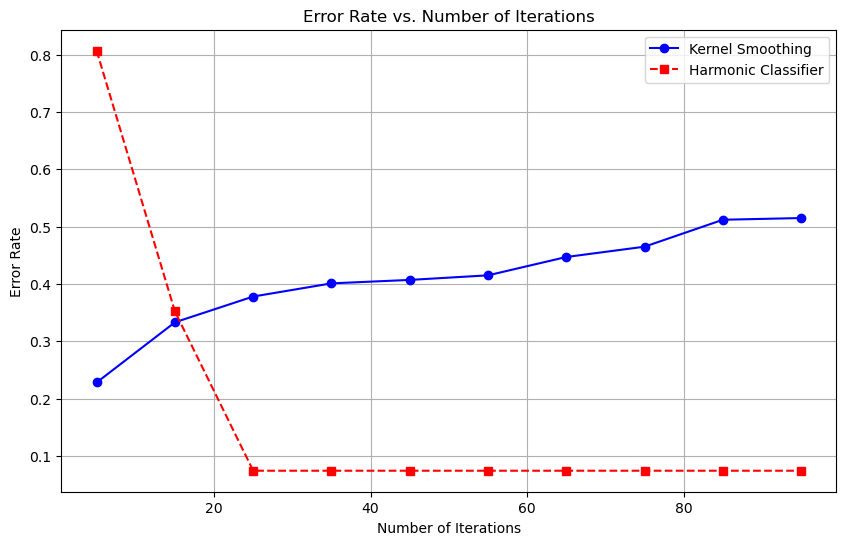

In [104]:
plt.figure(figsize=(10, 6))
plt.plot(list(iterations_list), error_rates_kernel, marker='o', linestyle='-', color='blue', label='Kernel Smoothing')
plt.plot(list(iterations_list), error_rates_harmonic, marker='s', linestyle='--', color='red', label='Harmonic Classifier')
plt.title('Error Rate vs. Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()

In [105]:
num_labeled = [50,100,200,500,700]
num_split = 10
error_rates_kernel_2 = []
error_rates_harmonic_2 = []
num = 20

for num in num_labeled:
    labeled_indices, unlabeled_indices = data_split(1000, num, num_split)

    predicted_probabilities = kernel_smooth(label, labeled_indices, W, iterations=20)
    predicted_probabilities_h = harmonic_classifier(label, labeled_indices, K, iterations=20)

    predicted_labels = np.argmax(predicted_probabilities, axis=1)
    predicted_labels_h = np.argmax(predicted_probabilities_h, axis=1)

    error_kernel = calculate_error(predicted_labels, label, 0, 1000)
    error_harmonic = calculate_error(predicted_labels_h, label, 0, 1000)

    error_rates_kernel_2.append(error_kernel)
    error_rates_harmonic_2.append(error_harmonic)
    print(f'Kernel Error for {num} labeled data: {error_kernel}')
    print(f'Harmonic Error for {num} labeled data: {error_harmonic}')

Kernel Error for 50 labeled data: 0.306
Harmonic Error for 50 labeled data: 0.136
Kernel Error for 100 labeled data: 0.34
Harmonic Error for 100 labeled data: 0.074
Kernel Error for 200 labeled data: 0.296
Harmonic Error for 200 labeled data: 0.06
Kernel Error for 500 labeled data: 0.286
Harmonic Error for 500 labeled data: 0.052
Kernel Error for 700 labeled data: 0.272
Harmonic Error for 700 labeled data: 0.052


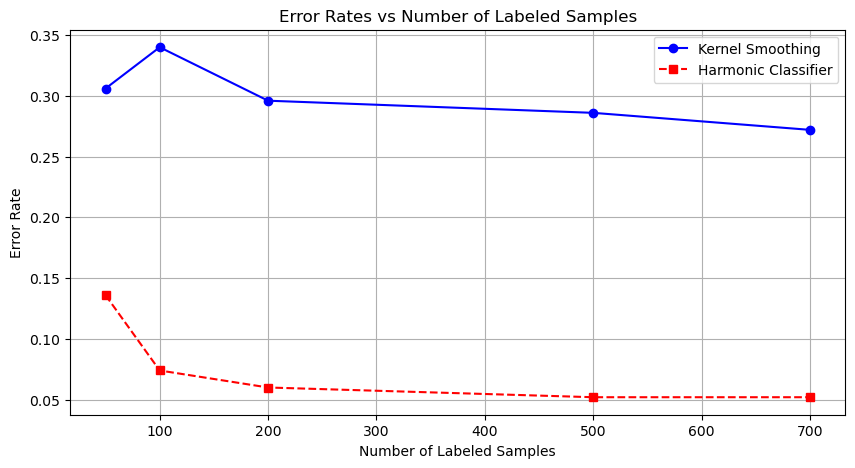

In [106]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(list(num_labeled), error_rates_kernel_2, marker='o', linestyle='-', color='blue', label='Kernel Smoothing')
plt.plot(list(num_labeled), error_rates_harmonic_2, marker='s', linestyle='--', color='red', label='Harmonic Classifier')
plt.title('Error Rates vs Number of Labeled Samples')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()

In [114]:
from sklearn.impute import SimpleImputer
def compute_adapted_weights(X, K,label,labeled_indices,beta):
    g = harmonic_classifier(label, labeled_indices, K, iterations =250, num_classes=20)
    c = g/(np.abs(g).sum(axis =0)[np.newaxis,:])

    c_normalized = c * (np.mean(np.linalg.norm(X, axis=1)) / np.mean(np.linalg.norm(c, axis=1)))##why
    c_normalized *= beta

    X_c = np.hstack((X, c))
    imputer = SimpleImputer(strategy='mean')
    X_c_filled = imputer.fit_transform(X_c)
    W = graph_construction(X_c_filled,25,20,sigma=1)

    return W


img = data_pca[:1000]
labels = label[:1000]


# choose first 500 data to be labeled
num_labels = 250
labeled_indices = np.arange(num_labels)
unlabeled_indices = np.arange(num_labels, 1000)

# predicted_probabilities = harmonic_classifier(labels, labeled_indices, K, num_classes=10,iterations =10)
# predicted_classes = np.argmax(predicted_probabilities, axis=1)

In [115]:
W = graph_construction(img, k, m, sigma)
K = random_walk(W)

predicted_probabilities = harmonic_classifier(label, labeled_indices, K)

In [116]:
contains_nan = np.isnan(predicted_probabilities).any()
contains_nan

False

In [117]:

W2 = compute_adapted_weights(img,K,label, labeled_indices, beta =1)
K2 = random_walk(W)


C:\Users\MSI\AppData\Local\Temp\ipykernel_25004\1093855846.py:4: RuntimeWarning: invalid value encountered in divide
  c = g/(np.abs(g).sum(axis =0)[np.newaxis,:])
E:\Anaconda\Lib\site-packages\sklearn\impute\_base.py:555: UserWarning: Skipping features without any observed values: [100]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [118]:
num_split = 10
error_rates_kernel_3 = []
error_rates_harmonic_3 = []


Beta = range(1,10,2)
for beta in Beta:
    labeled_indices, unlabeled_indices = data_split(1000, 250, num_split)

    predicted_probabilities = kernel_smooth(label, labeled_indices, W2, iterations=20)
    predicted_probabilities_h = harmonic_classifier(labels, labeled_indices, K2, iterations=20)

    predicted_labels = np.argmax(predicted_probabilities, axis=1)
    predicted_labels_h = np.argmax(predicted_probabilities_h, axis=1)

    error_kernel = calculate_error(predicted_labels, label, 0, 1000)
    error_harmonic = calculate_error(predicted_labels_h, label, 0, 1000)

    error_rates_kernel_3.append(error_kernel)
    error_rates_harmonic_3.append(error_harmonic)
    print(f'Kernel Error for {beta} : {error_kernel}')
    print(f'Harmonic Error for {beta}: {error_harmonic}')

Kernel Error for 1 : 0.286
Harmonic Error for 1: 0.052
Kernel Error for 3 : 0.313
Harmonic Error for 3: 0.053
Kernel Error for 5 : 0.292
Harmonic Error for 5: 0.053
Kernel Error for 7 : 0.295
Harmonic Error for 7: 0.055
Kernel Error for 9 : 0.294
Harmonic Error for 9: 0.054


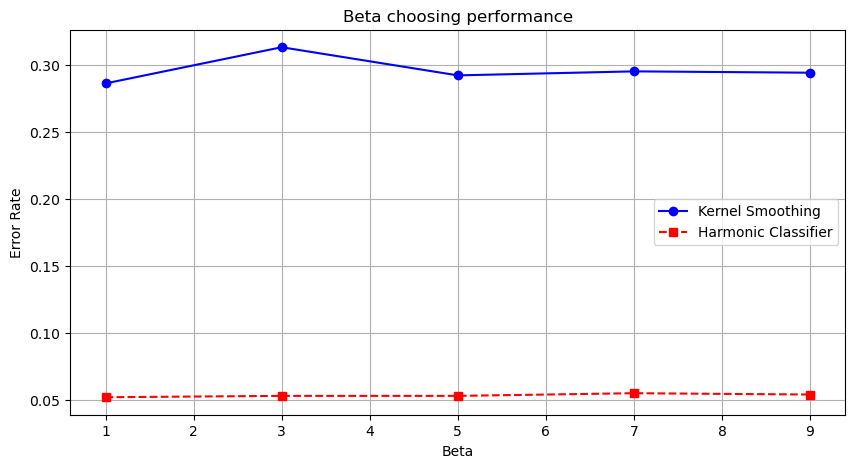

In [119]:

# Plotting
beta = [1,3,5,7,9]
plt.figure(figsize=(10, 5))
plt.plot(list(beta), error_rates_kernel_3, marker='o', linestyle='-', color='blue', label='Kernel Smoothing')
plt.plot(list(beta), error_rates_harmonic_3, marker='s', linestyle='--', color='red', label='Harmonic Classifier')
plt.title('Beta choosing performance')
plt.xlabel('Beta')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()

In [121]:
num_labels = 500
labeled_indices = np.arange(num_labels)

iterations_list = range(5, 100, 10)
error_rates_kernel_4 = []
error_rates_harmonic_4 = []

# Running loop for kernel_smooth
for iters in iterations_list:
    predicted_probabilities = kernel_smooth(label, labeled_indices, W2, iterations=iters)
    predicted_labels = np.argmax(predicted_probabilities, axis=1)
    error_kernel = calculate_error(predicted_labels, label, 0, 1000)
    print(error_kernel)
    error_rates_kernel_4.append(error_kernel)
    print(f'Kernel Smoothing Error at {iters} iterations: {error_kernel}')

# Running loop for harmonic_classifier
for iters in iterations_list:
    predicted_probabilities_h = harmonic_classifier(label, labeled_indices, K2, iters)
    predicted_labels_h = np.argmax(predicted_probabilities_h, axis=1)
    error_harmonic = calculate_error(predicted_labels_h, label, 0, 1000)
    error_rates_harmonic_4.append(error_harmonic)
    print(f'Harmonic Classifier Error at {iters} iterations: {error_harmonic}')

0.203
Kernel Smoothing Error at 5 iterations: 0.203
0.285
Kernel Smoothing Error at 15 iterations: 0.285
0.329
Kernel Smoothing Error at 25 iterations: 0.329
0.38
Kernel Smoothing Error at 35 iterations: 0.38
0.404
Kernel Smoothing Error at 45 iterations: 0.404
0.407
Kernel Smoothing Error at 55 iterations: 0.407
0.413
Kernel Smoothing Error at 65 iterations: 0.413
0.455
Kernel Smoothing Error at 75 iterations: 0.455
0.456
Kernel Smoothing Error at 85 iterations: 0.456
0.501
Kernel Smoothing Error at 95 iterations: 0.501
Harmonic Classifier Error at 5 iterations: 0.8
Harmonic Classifier Error at 15 iterations: 0.32
Harmonic Classifier Error at 25 iterations: 0.039
Harmonic Classifier Error at 35 iterations: 0.039
Harmonic Classifier Error at 45 iterations: 0.039
Harmonic Classifier Error at 55 iterations: 0.039
Harmonic Classifier Error at 65 iterations: 0.039
Harmonic Classifier Error at 75 iterations: 0.039
Harmonic Classifier Error at 85 iterations: 0.039
Harmonic Classifier Error a

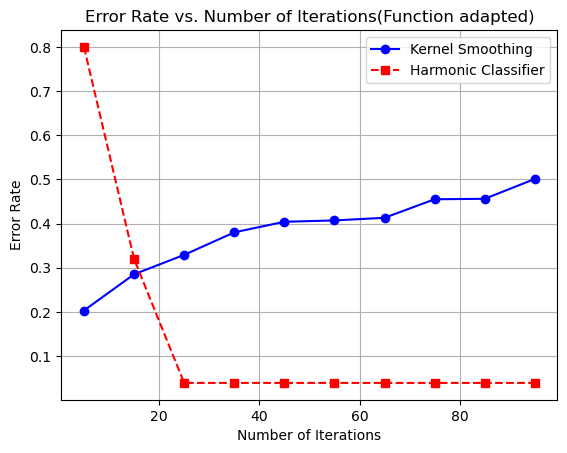

In [122]:
plt.plot(list(iterations_list), error_rates_kernel_4, marker='o', linestyle='-', color='blue', label='Kernel Smoothing')
plt.plot(list(iterations_list), error_rates_harmonic_4, marker='s', linestyle='--', color='red', label='Harmonic Classifier')
plt.title('Error Rate vs. Number of Iterations(Function adapted)')
plt.xlabel('Number of Iterations')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()

In [123]:
num_labeled = [50,100,200,500,700]
num_split = 10
error_rates_kernel_2 = []
error_rates_harmonic_2 = []
num = 20

for num in num_labeled:
    labeled_indices, unlabeled_indices = data_split(1000, num, num_split)

    predicted_probabilities = kernel_smooth(label, labeled_indices, W2, iterations=20)
    predicted_probabilities_h = harmonic_classifier(label, labeled_indices, K2, iterations=20)

    predicted_labels = np.argmax(predicted_probabilities, axis=1)
    predicted_labels_h = np.argmax(predicted_probabilities_h, axis=1)

    error_kernel = calculate_error(predicted_labels, label, 0, 1000)
    error_harmonic = calculate_error(predicted_labels_h, label, 0, 1000)

    error_rates_kernel_2.append(error_kernel)
    error_rates_harmonic_2.append(error_harmonic)
    print(f'Kernel Error for {num} labeled data: {error_kernel}')
    print(f'Harmonic Error for {num} labeled data: {error_harmonic}')

Kernel Error for 50 labeled data: 0.332
Harmonic Error for 50 labeled data: 0.115
Kernel Error for 100 labeled data: 0.27
Harmonic Error for 100 labeled data: 0.083
Kernel Error for 200 labeled data: 0.316
Harmonic Error for 200 labeled data: 0.056
Kernel Error for 500 labeled data: 0.272
Harmonic Error for 500 labeled data: 0.052
Kernel Error for 700 labeled data: 0.272
Harmonic Error for 700 labeled data: 0.052


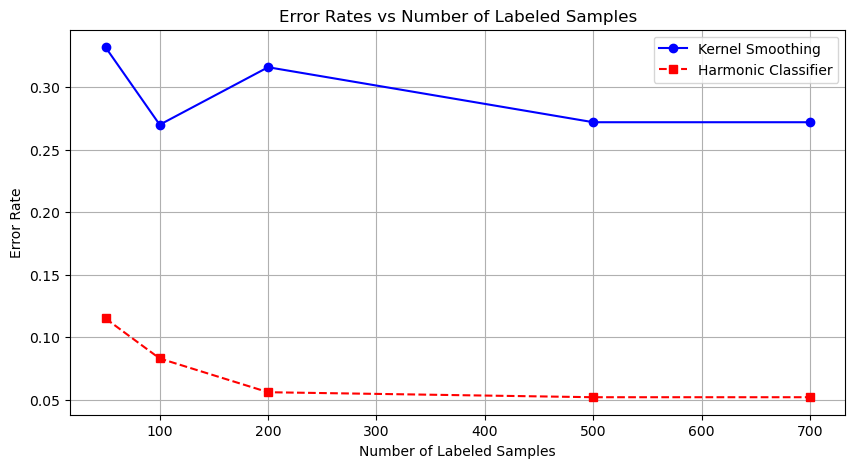

In [124]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(list(num_labeled), error_rates_kernel_2, marker='o', linestyle='-', color='blue', label='Kernel Smoothing')
plt.plot(list(num_labeled), error_rates_harmonic_2, marker='s', linestyle='--', color='red', label='Harmonic Classifier')
plt.title('Error Rates vs Number of Labeled Samples')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\MSI\AppData\Local\Temp\ipykernel_25004\1093855846.py:4: RuntimeWarning: invalid value encountered in divide
  c = g/(np.abs(g).sum(axis =0)[np.newaxis,:])
E:\Anaconda\Lib\site-packages\sklearn\impute\_base.py:555: UserWarning: Skipping features without any observed values: [100]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\MSI\AppData\Local\Temp\ipykernel_25004\1093855846.py:4: RuntimeWarning: invalid value encountered in divide
  c = g/(np.abs(g).sum(axis =0)[np.newaxis,:])
E:\Anaconda\Lib\site-packages\sklearn\impute\_base.py:555: UserWarning: Skipping features without any observed values: [100]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\MSI\AppData\Local\Temp\ipykernel_25004\1093855846.py:4: RuntimeWarning: invalid value encountered in divide
  c = g/(np.abs(g).sum(axis =0)[np.newaxis,:])
E:\Anaconda\Lib\site-packages\sklearn\impute\_base.py:555: UserWar

Text(0.5, 1.0, 'Runtime of Graph Construction vs. Number of Data')

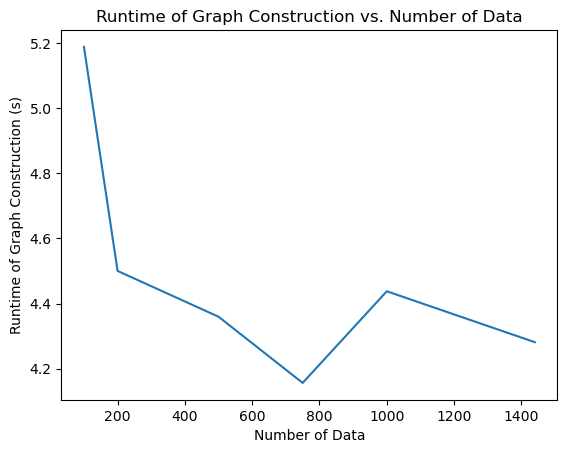

In [130]:
# runtime of graph construction with different total number
time_graph_construction = []
num_img = [100, 200, 500, 750, 1000, 1440]
for num in num_img:
    data = data_pca[:num]
    s = time.process_time()
    W2 = compute_adapted_weights(img,K2,labels,labeled_indices, beta = 5,)
    time_construction = time.process_time() - s
    time_graph_construction.append(time_construction)

plt.figure()
plt.plot(num_img, time_graph_construction)
plt.xlabel('Number of Data')
plt.ylabel('Runtime of Graph Construction (s)')
plt.title('Runtime of Graph Construction vs. Number of Data')

